<a href="https://colab.research.google.com/github/mansi1189/Natural-Language-Processing/blob/master/Named_entity_recognition%20using%20ELMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [0]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.drop(['POS'], axis =1)
data = data.fillna(method="ffill")
data.tail(12)

,Sentence #,Word,Tag
217570,Sentence: 9967,peace,O
217571,Sentence: 9967,and,O
217572,Sentence: 9967,prosperity,O
217573,Sentence: 9967,for,O
217574,Sentence: 9967,generations,O
217575,Sentence: 9967,to,O
217576,Sentence: 9967,come,O
217577,Sentence: 9967,.,O
217578,Sentence: 9968,Blades,B-art
217579,Sentence: 9968,Of,I-art


In [0]:
words = set(list(data['Word'].values))
words.add('PADword')
n_words = len(words)
n_words

16250

In [0]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
n_tags
tags

['B-org',
 'O',
 'B-per',
 'B-tim',
 'I-gpe',
 'I-tim',
 'I-org',
 'I-geo',
 'B-eve',
 'I-eve',
 'I-art',
 'I-nat',
 'B-gpe',
 'B-nat',
 'B-geo',
 'I-per',
 'B-art']

In [0]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [0]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [0]:
sentences = getter.sentences
print(len(sentences))

9968


In [0]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 70 words


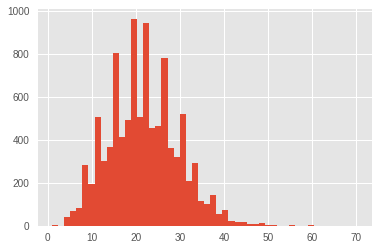

In [0]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences],bins=50)
plt.show()

In [0]:
max_len = 50
X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
new_X[25]

['Mr.',
 'Zhvania',
 'has',
 'met',
 'with',
 'a',
 'number',
 'of',
 'high-level',
 'U.S.',
 'officials',
 ',',
 'including',
 'National',
 'Security',
 'Advisor',
 'Condoleezza',
 'Rice',
 '.',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword']

In [0]:
from keras.preprocessing.sequence import pad_sequences
tags2index = {t:i for i,t in enumerate(tags)}
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
len(y[25])

50

In [0]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.13.1)


In [0]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K

In [0]:
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2018)

In [0]:
len(X_te[0])

50

In [0]:
sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [0]:
batch_size = 32
def ElmoEmbedding(x):
    return elmo_model(inputs={"tokens": tf.squeeze(tf.cast(x,    tf.string)),"sequence_len": tf.constant(batch_size*[max_len])
                     },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [0]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

In [0]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0405 08:24:34.065406 139703068346240 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 50, 1024)     0           input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 50, 1024)     6295552     lambda_2[0][0]                   
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 50, 1024)     6295552     bidirectional_3[0][0]            
__________________________________________________________________________________________________
add_2 (Add

In [0]:
model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

In [0]:

X_tr, X_val = X_tr[:280*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:280*batch_size], y_tr[-135*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [0]:
np.array(X_val)

array([['Mr.', 'Gbagbo', 'says', ..., 'PADword', 'PADword', 'PADword'],
       ['The', 'United', 'Nations', ..., 'PADword', 'PADword', 'PADword'],
       ['The', 'latest', 'fighting', ..., 'PADword', 'PADword',
        'PADword'],
       ...,
       ['The', 'fighting', 'took', ..., 'PADword', 'PADword', 'PADword'],
       ['Afghan', 'President', 'Hamid', ..., 'PADword', 'PADword',
        'PADword'],
       ['The', 'group', 'had', ..., 'PADword', 'PADword', 'PADword']],
      dtype='<U27')

In [0]:
np.array(X_tr)

array([['The', 'Lebanese', 'army', ..., 'PADword', 'PADword', 'PADword'],
       ['He', 'said', 'that', ..., 'PADword', 'PADword', 'PADword'],
       ['German', 'Chancellor', 'Gerhard', ..., 'former', 'Soviet',
        'Union'],
       ...,
       ['The', 'fighting', 'took', ..., 'PADword', 'PADword', 'PADword'],
       ['Afghan', 'President', 'Hamid', ..., 'PADword', 'PADword',
        'PADword'],
       ['The', 'group', 'had', ..., 'PADword', 'PADword', 'PADword']],
      dtype='<U27')

In [0]:
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),batch_size=batch_size, epochs=3, verbose=1)

Train on 8960 samples, validate on 4320 samples
Epoch 1/3
8960/8960 [==============================] - 403s 45ms/step - loss: 0.0408 - val_loss: 0.0302
Epoch 2/3
8960/8960 [==============================] - 404s 45ms/step - loss: 0.0321 - val_loss: 0.0213
Epoch 3/3
8960/8960 [==============================] - 402s 45ms/step - loss: 0.0247 - val_loss: 0.0169


In [0]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
X_te = X_te[:32*batch_size]
test_pred = model.predict(np.array(X_te), verbose=1)

992/992 [==============================] - 24s 24ms/step


In [0]:
!pip install seqeval

In [0]:
idx2tag = {i: w for w, i in tags2index.items()}

In [0]:
print(idx2tag[0])

B-org


In [0]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out
def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out

In [0]:
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:31*32])

In [0]:
print(classification_report(test_labels, pred_labels))

             precision    recall  f1-score   support

        tim       0.81      0.82      0.82       391
        org       0.69      0.61      0.65       433
        per       0.67      0.70      0.68       344
        nat       0.25      0.25      0.25         4
        gpe       0.91      0.88      0.90       366
        geo       0.77      0.90      0.83       745
        eve       0.22      0.25      0.24         8
        art       0.29      0.29      0.29         7

avg / total       0.76      0.79      0.78      2298



In [0]:
i = 30
p = model.predict(np.array(X_te[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "__PAD__":
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))

Word            Pred : (True)
The            :O     (O)
blast          :O     (O)
was            :O     (O)
the            :O     (O)
biggest        :O     (O)
bombing        :O     (O)
in             :O     (O)
Iraq           :B-geo (B-geo)
since          :O     (B-tim)
April          :B-tim (I-tim)
29th           :I-tim (I-tim)
,              :O     (O)
when           :O     (O)
more           :O     (O)
than           :O     (O)
50             :O     (O)
people         :O     (O)
were           :O     (O)
killed         :O     (O)
in             :O     (O)
bombings       :O     (O)
in             :O     (O)
Shi'ite        :B-geo (O)
districts      :O     (O)
in             :O     (O)
Baghdad        :B-geo (B-geo)
.              :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword        :O     (O)
PADword       

In [0]:
hist = pd.DataFrame(history.history)

In [0]:
hist

,loss,val_loss
0,0.040829,0.030185
1,0.032080,0.021322
2,0.024728,0.016858


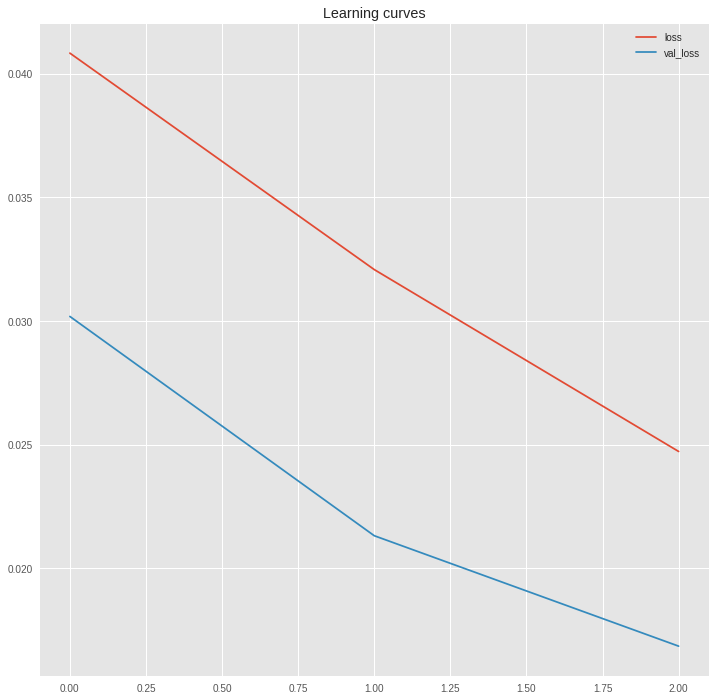

In [0]:
plt.figure(figsize=(12,12))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Learning curves")
plt.legend()
plt.show()